# ADS Similarity Search Score Distribution Experiment

This notebook analyzes the similarity score distribution from ADS similarity search results.

## Experiment Plan
1. Take a random bibcode from WUMaCat catalogue
2. Run similarity search and retrieve information about first 2000 papers
3. Plot score vs rank/position to visualize the score distribution curve


In [2]:
# Setup
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from dotenv import load_dotenv

# Add project src to path
project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

# Load environment variables
load_dotenv(project_root / ".env")

# Import ADS parser functions
from ads_parser import find_similar_papers, test_ads_connection

# Set up matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🔧 Setup completed!")
print(f"📁 Project root: {project_root}")

# Test ADS connection
print("\n" + "="*60)
test_ads_connection()


🔧 Setup completed!
📁 Project root: /Users/wera/Max_astro/GitProjects/phd_agent

🔍 Testing ADS API connection...
✅ ADS API connection successful!
   Found 1104 total results
   Retrieved 1 documents


True

In [8]:
# Step 1: Select random bibcode from WUMaCat catalogue
wumacat_file = project_root / "data" / "WUMaCat.csv"

print("📂 Loading WUMaCat catalogue...")
wumacat_df = pd.read_csv(wumacat_file)
print(f"✅ Loaded {len(wumacat_df)} entries")

# Get valid bibcodes
valid_bibcodes = wumacat_df[wumacat_df['Bibcode'].notna() & (wumacat_df['Bibcode'] != '')]['Bibcode'].tolist()
print(f"📄 Found {len(valid_bibcodes)} valid bibcodes")

# Select random bibcode
random_bibcode = random.choice(valid_bibcodes)
print(f"\n🎲 Random bibcode selected: {random_bibcode}")

# Show info about selected entry
selected_entry = wumacat_df[wumacat_df['Bibcode'] == random_bibcode].iloc[0]
print(f"   Name: {selected_entry['Name']}")
print(f"   Type: {selected_entry['Type']}")

print(f"\n🔍 This will be our reference paper for similarity search")


📂 Loading WUMaCat catalogue...
✅ Loaded 688 entries
📄 Found 688 valid bibcodes

🎲 Random bibcode selected: 2015AJ....149..194L
   Name: DK Cyg
   Type: A

🔍 This will be our reference paper for similarity search


In [9]:
# Step 2: Run similarity search for 2000 papers
print(f"🚀 Starting similarity search for {random_bibcode}")
print("🔍 Retrieving first 2000 similar papers...")
print("=" * 60)

# Run similarity search
similarity_result = find_similar_papers(
    bibcode=random_bibcode,
    max_results=2000,
    fields=['bibcode', 'title', 'year', 'score', 'citation_count']
)

if similarity_result:
    papers = similarity_result['papers']
    print(f"\n📊 Similarity search completed!")
    print(f"   Reference: {similarity_result['reference_bibcode']}")
    print(f"   Total found: {similarity_result['total_found']:,}")
    print(f"   Retrieved: {len(papers)} papers")
    
    # Extract scores for analysis
    scores = [paper.get('score', 0) for paper in papers]
    ranks = list(range(1, len(papers) + 1))
    
    print(f"\n📈 Score statistics:")
    print(f"   Highest score: {max(scores):.2f}")
    print(f"   Lowest score: {min(scores):.2f}")
    print(f"   Score range: {max(scores) - min(scores):.2f}")
    print(f"   Average score: {np.mean(scores):.2f}")
    print(f"   Median score: {np.median(scores):.2f}")
    
else:
    print("❌ Similarity search failed!")
    papers = []
    scores = []
    ranks = []


🚀 Starting similarity search for 2015AJ....149..194L
🔍 Retrieving first 2000 similar papers...
🔍 Searching for papers similar to: 2015AJ....149..194L
   Query: similar(2015AJ....149..194L)
   Max results: 2000
   Fields: ['bibcode', 'title', 'year', 'score', 'citation_count']
   Rate limit remaining: 4915
✅ Found 19437905 similar papers
   Retrieved: 2000 papers

📊 Similarity search completed!
   Reference: 2015AJ....149..194L
   Total found: 19,437,905
   Retrieved: 2000 papers

📈 Score statistics:
   Highest score: 140.06
   Lowest score: 47.00
   Score range: 93.06
   Average score: 57.99
   Median score: 54.19


📊 Creating score distribution plot...


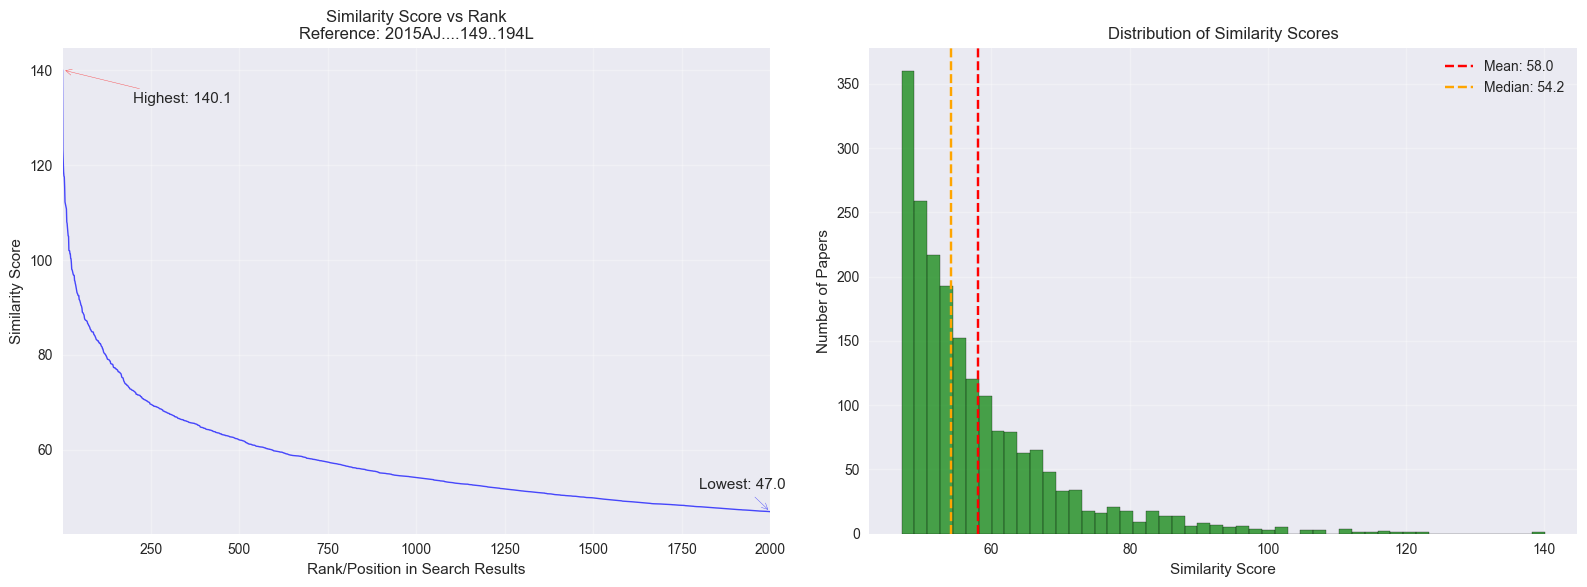


📋 Additional insights:
   Papers with score > 100: 25
   Papers with score > 80: 122
   Papers with score > 50: 1477

📊 Score percentiles:
   90th percentile: 72.47
   75th percentile: 62.12
   50th percentile: 54.19
   25th percentile: 49.89
   10th percentile: 48.03


In [10]:
# Step 3: Plot score vs rank/position curve
if scores and ranks:
    print("📊 Creating score distribution plot...")
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Score vs Rank (full range)
    ax1.plot(ranks, scores, 'b-', linewidth=1, alpha=0.7)
    ax1.set_xlabel('Rank/Position in Search Results')
    ax1.set_ylabel('Similarity Score')
    ax1.set_title(f'Similarity Score vs Rank\nReference: {random_bibcode}')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, len(ranks))
    
    # Add some annotation
    ax1.annotate(f'Highest: {max(scores):.1f}', 
                xy=(1, max(scores)), xytext=(len(ranks)*0.1, max(scores)*0.95),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
    ax1.annotate(f'Lowest: {min(scores):.1f}', 
                xy=(len(ranks), min(scores)), xytext=(len(ranks)*0.9, min(scores)*1.1),
                arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7))
    
    # Plot 2: Score distribution histogram
    ax2.hist(scores, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Similarity Score')
    ax2.set_ylabel('Number of Papers')
    ax2.set_title('Distribution of Similarity Scores')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(np.mean(scores), color='red', linestyle='--', 
                label=f'Mean: {np.mean(scores):.1f}')
    ax2.axvline(np.median(scores), color='orange', linestyle='--', 
                label=f'Median: {np.median(scores):.1f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis
    print(f"\n📋 Additional insights:")
    print(f"   Papers with score > 100: {sum(1 for s in scores if s > 100)}")
    print(f"   Papers with score > 80: {sum(1 for s in scores if s > 80)}")
    print(f"   Papers with score > 50: {sum(1 for s in scores if s > 50)}")
    
    # Find score at different percentiles
    percentiles = [90, 75, 50, 25, 10]
    print(f"\n📊 Score percentiles:")
    for p in percentiles:
        score_at_p = np.percentile(scores, p)
        print(f"   {p}th percentile: {score_at_p:.2f}")
        
else:
    print("❌ No data available for plotting")


# Step 3: Overlap Analysis with WUMaCat at Different Score Thresholds

We'll analyze how the overlap with WUMaCat papers changes as we vary the similarity score threshold from 100 down to 40.


In [11]:
# Step 3: Calculate overlap at different score thresholds
if similarity_result and papers:
    print("📊 Calculating WUMaCat overlap at different score thresholds...")
    
    # Get WUMaCat bibcodes for comparison
    wumacat_bibcodes = set(wumacat_df['Bibcode'].dropna().str.strip())
    print(f"📄 WUMaCat contains {len(wumacat_bibcodes)} unique bibcodes")
    
    # Extract bibcodes from similarity results
    similarity_bibcodes = [paper.get('bibcode') for paper in papers if paper.get('bibcode')]
    print(f"🔍 Similarity search returned {len(similarity_bibcodes)} papers")
    
    # Define score thresholds to test
    thresholds = [100, 90, 80, 70, 60, 50, 40]
    
    # Initialize results storage
    threshold_results = {}
    
    for threshold in thresholds:
        # Filter papers by score threshold
        filtered_papers = [paper for paper in papers 
                          if paper.get('score', 0) >= threshold]
        
        # Get bibcodes for filtered papers
        filtered_bibcodes = set([paper.get('bibcode') for paper in filtered_papers 
                               if paper.get('bibcode')])
        
        # Calculate overlap with WUMaCat
        overlap = filtered_bibcodes.intersection(wumacat_bibcodes)
        
        # Store results
        threshold_results[threshold] = {
            'num_papers': len(filtered_papers),
            'num_overlap': len(overlap),
            'overlap_percentage': (len(overlap) / len(filtered_papers) * 100) if len(filtered_papers) > 0 else 0,
            'overlap_bibcodes': overlap
        }
        
        print(f"📈 Threshold ≥{threshold}: {len(filtered_papers)} papers, "
              f"{len(overlap)} overlap ({threshold_results[threshold]['overlap_percentage']:.1f}%)")
    
    print("\\n✅ Overlap analysis completed!")
    
else:
    print("❌ No similarity results available for overlap analysis")


📊 Calculating WUMaCat overlap at different score thresholds...
📄 WUMaCat contains 424 unique bibcodes
🔍 Similarity search returned 2000 papers
📈 Threshold ≥100: 25 papers, 9 overlap (36.0%)
📈 Threshold ≥90: 55 papers, 19 overlap (34.5%)
📈 Threshold ≥80: 122 papers, 36 overlap (29.5%)
📈 Threshold ≥70: 246 papers, 73 overlap (29.7%)
📈 Threshold ≥60: 593 papers, 128 overlap (21.6%)
📈 Threshold ≥50: 1477 papers, 188 overlap (12.7%)
📈 Threshold ≥40: 2000 papers, 205 overlap (10.2%)
\n✅ Overlap analysis completed!


# Step 4: Plot Overlap Analysis Results

Create visualizations showing how the overlap percentage and number of papers change with different score thresholds.


📊 Creating overlap analysis plots...


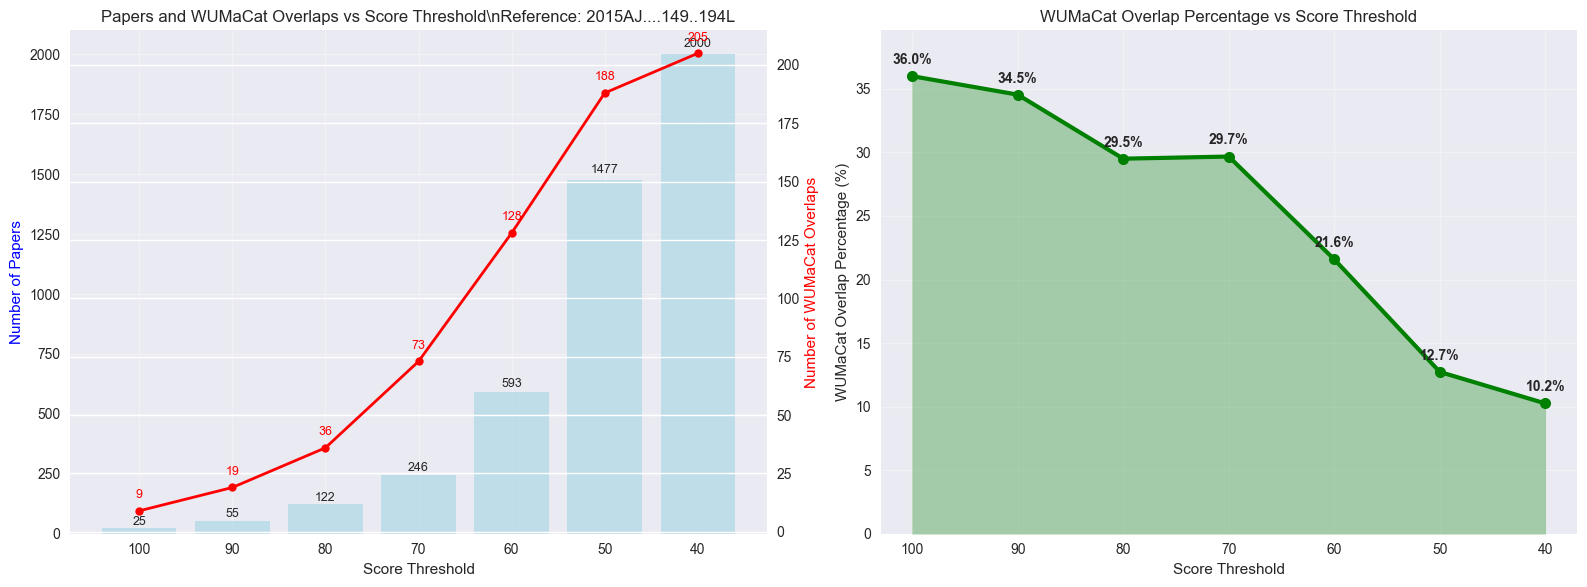

\n📋 Summary Table:
Threshold  Papers     Overlaps   Overlap %    Notes
--------------------------------------------------------------------------------
≥100       25         9          36.0       % High overlap
≥90        55         19         34.5       % High overlap
≥80        122        36         29.5       % High overlap
≥70        246        73         29.7       % High overlap
≥60        593        128        21.6       % High overlap
≥50        1477       188        12.7       % Medium overlap
≥40        2000       205        10.2       % Medium overlap
\n📊 Key insights:
   • Highest overlap percentage: 36.0% at threshold ≥100
   • Total unique WUMaCat papers found: 205
   • Score range in results: 47.0 - 140.1
   • WUMaCat papers found (any score): 205
   • WUMaCat coverage: 48.35% of WUMaCat catalogue


In [12]:
# Step 4: Plot overlap analysis results
if 'threshold_results' in locals() and threshold_results:
    print("📊 Creating overlap analysis plots...")
    
    # Extract data for plotting
    thresholds_list = sorted(threshold_results.keys(), reverse=True)  # High to low
    num_papers = [threshold_results[t]['num_papers'] for t in thresholds_list]
    overlap_percentages = [threshold_results[t]['overlap_percentage'] for t in thresholds_list]
    num_overlaps = [threshold_results[t]['num_overlap'] for t in thresholds_list]
    
    # Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Number of papers vs threshold
    ax1_twin = ax1.twinx()
    
    # Bar plot for number of papers
    bars1 = ax1.bar([str(t) for t in thresholds_list], num_papers, 
                    alpha=0.7, color='lightblue', label='Total Papers')
    
    # Line plot for number of overlaps
    line1 = ax1_twin.plot([str(t) for t in thresholds_list], num_overlaps, 
                         'ro-', linewidth=2, markersize=6, label='WUMaCat Overlaps')
    
    ax1.set_xlabel('Score Threshold')
    ax1.set_ylabel('Number of Papers', color='blue')
    ax1_twin.set_ylabel('Number of WUMaCat Overlaps', color='red')
    ax1.set_title(f'Papers and WUMaCat Overlaps vs Score Threshold\\nReference: {random_bibcode}')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, overlap) in enumerate(zip(bars1, num_overlaps)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)
        ax1_twin.text(i, overlap + max(num_overlaps)*0.02,
                     f'{overlap}', ha='center', va='bottom', fontsize=9, color='red')
    
    # Plot 2: Overlap percentage vs threshold
    ax2.plot([str(t) for t in thresholds_list], overlap_percentages, 
             'go-', linewidth=3, markersize=8, label='Overlap Percentage')
    ax2.fill_between([str(t) for t in thresholds_list], overlap_percentages, 
                     alpha=0.3, color='green')
    
    ax2.set_xlabel('Score Threshold')
    ax2.set_ylabel('WUMaCat Overlap Percentage (%)')
    ax2.set_title('WUMaCat Overlap Percentage vs Score Threshold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(overlap_percentages) * 1.1 if overlap_percentages else 1)
    
    # Add percentage labels
    for i, (threshold, percentage) in enumerate(zip(thresholds_list, overlap_percentages)):
        ax2.text(i, percentage + max(overlap_percentages)*0.02 if overlap_percentages else 0.5,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print(f"\\n📋 Summary Table:")
    print("="*80)
    print(f"{'Threshold':<10} {'Papers':<10} {'Overlaps':<10} {'Overlap %':<12} {'Notes'}")
    print("-"*80)
    
    for threshold in thresholds_list:
        result = threshold_results[threshold]
        notes = ""
        if result['overlap_percentage'] > 15:
            notes = "High overlap"
        elif result['overlap_percentage'] > 5:
            notes = "Medium overlap"
        elif result['overlap_percentage'] > 0:
            notes = "Low overlap"
        else:
            notes = "No overlap"
            
        print(f"≥{threshold:<9} {result['num_papers']:<10} {result['num_overlap']:<10} "
              f"{result['overlap_percentage']:<11.1f}% {notes}")
    
    print("\\n📊 Key insights:")
    if overlap_percentages:
        max_overlap_idx = overlap_percentages.index(max(overlap_percentages))
        max_threshold = thresholds_list[max_overlap_idx]
        print(f"   • Highest overlap percentage: {max(overlap_percentages):.1f}% at threshold ≥{max_threshold}")
        print(f"   • Total unique WUMaCat papers found: {len(set().union(*[r['overlap_bibcodes'] for r in threshold_results.values()]))}")
        print(f"   • Score range in results: {min(scores):.1f} - {max(scores):.1f}")
        
        # Calculate efficiency metrics
        if threshold_results[thresholds_list[-1]]['num_papers'] > 0:  # Lowest threshold
            total_wumacat_found = threshold_results[thresholds_list[-1]]['num_overlap']
            print(f"   • WUMaCat papers found (any score): {total_wumacat_found}")
            print(f"   • WUMaCat coverage: {total_wumacat_found/len(wumacat_bibcodes)*100:.2f}% of WUMaCat catalogue")
    
else:
    print("❌ No threshold results available for plotting")


# Step 5: Iterative Similarity Search for Maximum WUMaCat Coverage

This experiment will iteratively select random WUMaCat papers, run similarity searches, and accumulate unique overlapping papers until we reach 95% coverage of the WUMaCat catalogue or use more than 9000 reference papers.


In [15]:
# Step 5: Iterative similarity search for maximum WUMaCat coverage
import time
import random

print("🔄 Starting iterative similarity search experiment...")
print("=" * 70)

# Initialize variables
wumacat_bibcodes = set(wumacat_df['Bibcode'].dropna().str.strip())
total_wumacat_papers = len(wumacat_bibcodes)
unique_overlapped_bibcodes = set()  # Accumulate unique overlaps
unique_non_wumacat_bibcodes = set()  # Accumulate unique papers NOT in WUMaCat
chosen_papers_count = 0
iteration = 0
target_coverage = 95.0  # 95%
max_papers = 9000
max_iterations = 10  # Maximum number of iterations

print(f"📊 Target: {target_coverage}% coverage of {total_wumacat_papers} WUMaCat papers")
print(f"📊 Maximum reference papers: {max_papers}")
print(f"📊 Maximum iterations: {max_iterations}")
print(f"📊 Starting coverage: {len(unique_overlapped_bibcodes)} papers (0.0%)")
print(f"📊 Starting non-WUMaCat papers: {len(unique_non_wumacat_bibcodes)} papers")
print()

# Track progress for analysis
progress_log = []

# Main while loop
while True:
    iteration += 1
    print(f"🔄 Iteration {iteration}:")
    
    # 1. Take a random paper from WUMaCat
    random_wumacat_bibcode = random.choice(list(wumacat_bibcodes))
    chosen_papers_count += 1
    
    print(f"   📄 Selected: {random_wumacat_bibcode}")
    
    # 2. Make similarity search
    similarity_result = find_similar_papers(
        bibcode=random_wumacat_bibcode,
        max_results=2000,  # Get plenty of results
        fields=['bibcode', 'score']
    )
    
    if not similarity_result or not similarity_result.get('papers'):
        print(f"   ❌ No similarity results for {random_wumacat_bibcode}")
        current_coverage = len(unique_overlapped_bibcodes) / total_wumacat_papers * 100
        
        # Log progress
        progress_log.append({
            'iteration': iteration,
            'reference_bibcode': random_wumacat_bibcode,
            'papers_retrieved': 0,
            'papers_after_filter': 0,
            'new_overlaps': 0,
            'total_unique_overlaps': len(unique_overlapped_bibcodes),
            'coverage_percentage': current_coverage,
            'chosen_papers_count': chosen_papers_count
        })
        
        # Check stopping conditions
        if current_coverage >= target_coverage:
            print(f"   🎯 Target coverage reached: {current_coverage:.2f}%")
            break
        if chosen_papers_count >= max_papers:
            print(f"   🛑 Maximum papers limit reached: {chosen_papers_count}")
            break
        if iteration >= max_iterations:
            print(f"   🛑 Maximum iterations reached: {iteration}")
            break
            
        continue
    
    papers = similarity_result['papers']
    scores = [paper.get('score', 0) for paper in papers]
    
    # 3. Use mean as threshold to filter papers
    mean_score = np.mean(scores) if scores else 0
    filtered_papers = [paper for paper in papers if paper.get('score', 0) >= mean_score]
    
    print(f"   📊 Retrieved: {len(papers)} papers, Mean score: {mean_score:.2f}")
    print(f"   📊 After mean filter: {len(filtered_papers)} papers")
    
    # 4. Overlap with unique WUMaCat bibcodes and separate non-WUMaCat papers
    filtered_bibcodes = set([paper.get('bibcode') for paper in filtered_papers 
                           if paper.get('bibcode')])
    overlap_with_wumacat = filtered_bibcodes.intersection(wumacat_bibcodes)
    non_wumacat_papers = filtered_bibcodes - wumacat_bibcodes  # Papers NOT in WUMaCat
    
    # 5. Add unique overlapped bibcodes and non-WUMaCat papers to our collections
    new_overlaps = overlap_with_wumacat - unique_overlapped_bibcodes
    new_non_wumacat = non_wumacat_papers - unique_non_wumacat_bibcodes
    unique_overlapped_bibcodes.update(overlap_with_wumacat)
    unique_non_wumacat_bibcodes.update(non_wumacat_papers)
    
    # Calculate current coverage percentage
    current_coverage = len(unique_overlapped_bibcodes) / total_wumacat_papers * 100
    
    print(f"   📈 WUMaCat overlap: {len(overlap_with_wumacat)} papers, New: {len(new_overlaps)}")
    print(f"   📈 Non-WUMaCat papers: {len(non_wumacat_papers)} papers, New: {len(new_non_wumacat)}")
    print(f"   📊 Total unique WUMaCat overlaps: {len(unique_overlapped_bibcodes)}")
    print(f"   📊 Total unique non-WUMaCat papers: {len(unique_non_wumacat_bibcodes)}")
    print(f"   📊 Coverage: {current_coverage:.2f}%")
    
    # Log progress
    progress_log.append({
        'iteration': iteration,
        'reference_bibcode': random_wumacat_bibcode,
        'papers_retrieved': len(papers),
        'mean_score': mean_score,
        'papers_after_filter': len(filtered_papers),
        'overlap_with_wumacat': len(overlap_with_wumacat),
        'new_overlaps': len(new_overlaps),
        'non_wumacat_papers': len(non_wumacat_papers),
        'new_non_wumacat': len(new_non_wumacat),
        'total_unique_overlaps': len(unique_overlapped_bibcodes),
        'total_unique_non_wumacat': len(unique_non_wumacat_bibcodes),
        'coverage_percentage': current_coverage,
        'chosen_papers_count': chosen_papers_count
    })
    
    # 6. Check stopping conditions
    if current_coverage >= target_coverage:
        print(f"   🎯 Target coverage reached: {current_coverage:.2f}%")
        break
    
    if chosen_papers_count >= max_papers:
        print(f"   🛑 Maximum papers limit reached: {chosen_papers_count}")
        break
    
    if iteration >= max_iterations:
        print(f"   🛑 Maximum iterations reached: {iteration}")
        break
    
    # Add small delay to be respectful to the API
    time.sleep(1)
    print()

print()
print("=" * 70)
print("✅ Iterative experiment completed!")
print(f"📊 Final statistics:")
print(f"   • Iterations: {iteration}")
print(f"   • Reference papers used: {chosen_papers_count}")
print(f"   • Unique WUMaCat papers found: {len(unique_overlapped_bibcodes)}")
print(f"   • Unique non-WUMaCat papers found: {len(unique_non_wumacat_bibcodes)}")
print(f"   • Final coverage: {len(unique_overlapped_bibcodes) / total_wumacat_papers * 100:.2f}%")
print(f"   • Papers remaining: {total_wumacat_papers - len(unique_overlapped_bibcodes)}")
print(f"   • Total unique papers discovered: {len(unique_overlapped_bibcodes) + len(unique_non_wumacat_bibcodes)}")

# Convert progress log to DataFrame for analysis
progress_df = pd.DataFrame(progress_log)
print(f"\\n📋 Progress data saved with {len(progress_df)} iterations")


🔄 Starting iterative similarity search experiment...
📊 Target: 95.0% coverage of 424 WUMaCat papers
📊 Maximum reference papers: 9000
📊 Maximum iterations: 10
📊 Starting coverage: 0 papers (0.0%)
📊 Starting non-WUMaCat papers: 0 papers

🔄 Iteration 1:
   📄 Selected: 2017PASJ...69...37Z
🔍 Searching for papers similar to: 2017PASJ...69...37Z
   Query: similar(2017PASJ...69...37Z)
   Max results: 2000
   Fields: ['bibcode', 'score']
   Rate limit remaining: 4881
✅ Found 14047249 similar papers
   Retrieved: 2000 papers
   📊 Retrieved: 2000 papers, Mean score: 58.23
   📊 After mean filter: 707 papers
   📈 WUMaCat overlap: 200 papers, New: 200
   📈 Non-WUMaCat papers: 507 papers, New: 507
   📊 Total unique WUMaCat overlaps: 200
   📊 Total unique non-WUMaCat papers: 507
   📊 Coverage: 47.17%

🔄 Iteration 2:
   📄 Selected: 2009AJ....138.1465H
🔍 Searching for papers similar to: 2009AJ....138.1465H
   Query: similar(2009AJ....138.1465H)
   Max results: 2000
   Fields: ['bibcode', 'score']
   Rat

📊 Creating progress visualization...


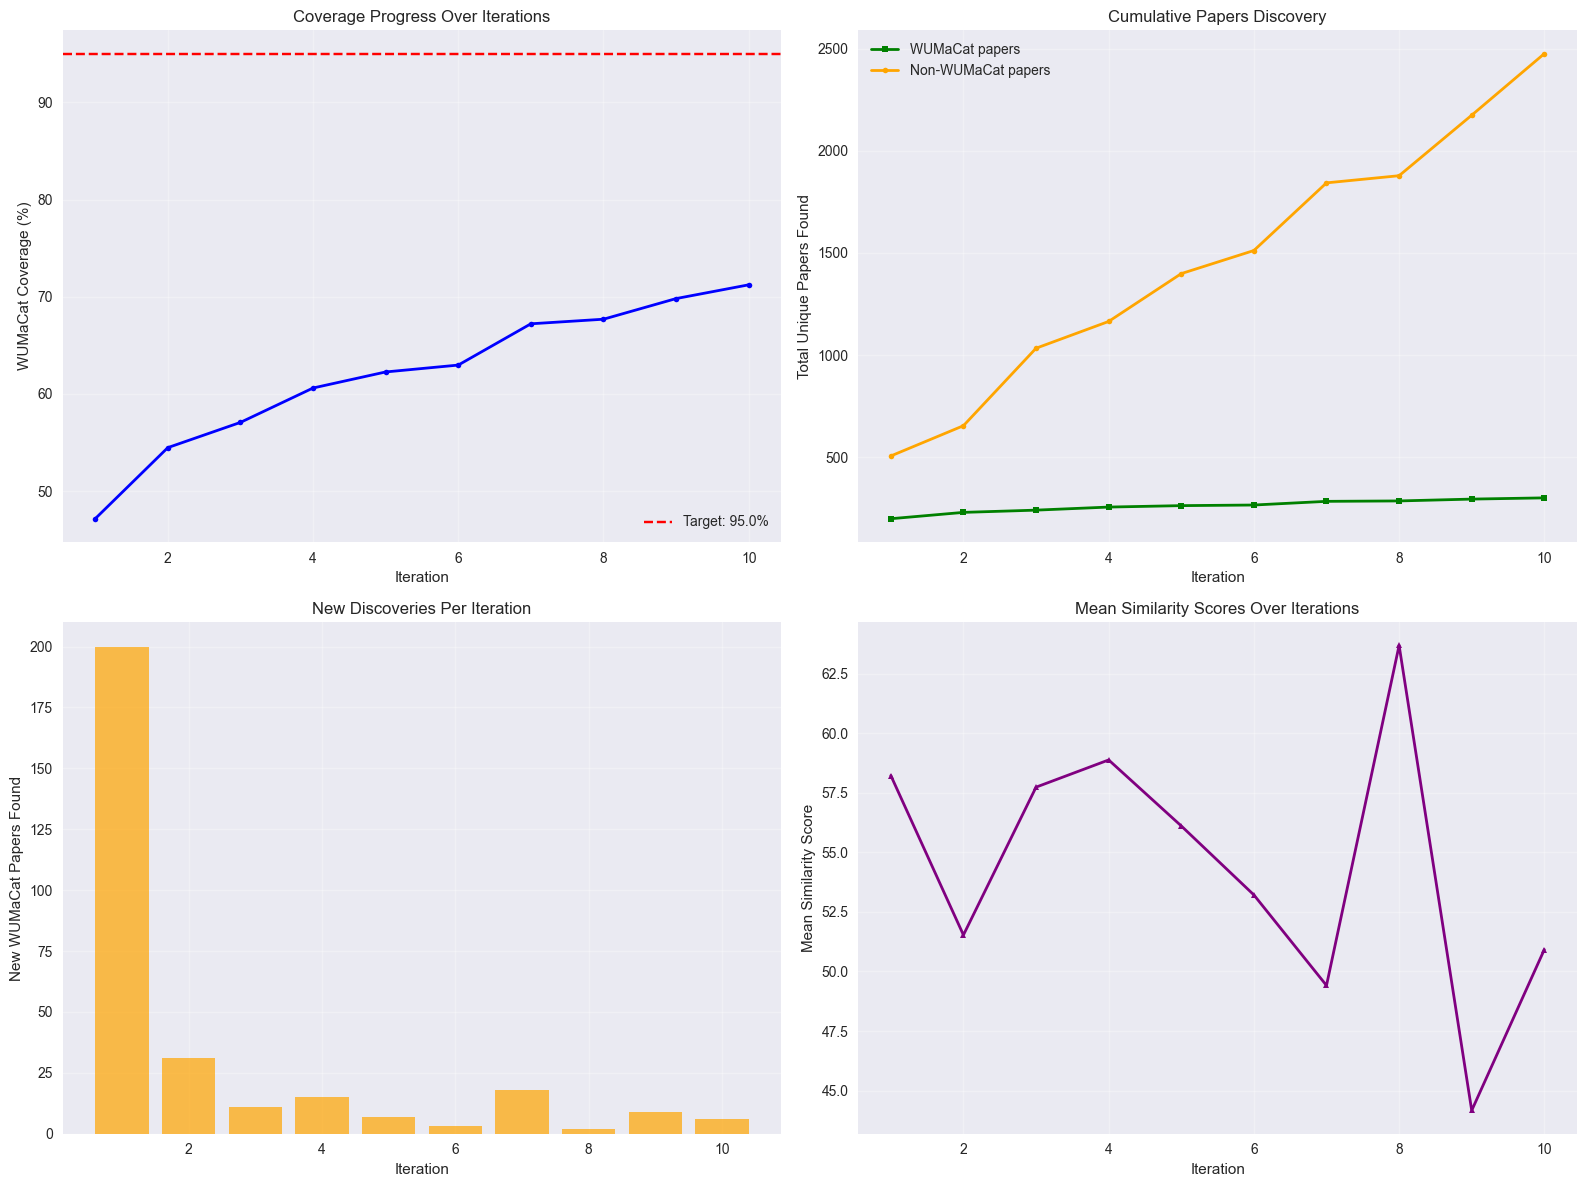

\n📊 Experiment Analysis:
Total iterations: 10
Final coverage: 71.23%
Total unique WUMaCat papers found: 302
Total unique non-WUMaCat papers found: 2475
Total papers discovered: 2777
Average new WUMaCat papers per iteration: 30.2
Average new non-WUMaCat papers per iteration: 247.5
Average similarity score: 54.39
Score range: 44.17 - 63.69
\n🏆 Most productive iteration: 1
   Reference paper: 2017PASJ...69...37Z
   New papers found: 200


In [16]:
# Visualize the iterative experiment progress
if 'progress_df' in locals() and len(progress_df) > 0:
    print("📊 Creating progress visualization...")
    
    # Create comprehensive progress plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Coverage percentage over iterations
    ax1.plot(progress_df['iteration'], progress_df['coverage_percentage'], 
             'b-', linewidth=2, marker='o', markersize=4)
    ax1.axhline(y=target_coverage, color='red', linestyle='--', 
                label=f'Target: {target_coverage}%')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('WUMaCat Coverage (%)')
    ax1.set_title('Coverage Progress Over Iterations')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Cumulative unique overlaps found (both WUMaCat and non-WUMaCat)
    ax2.plot(progress_df['iteration'], progress_df['total_unique_overlaps'], 
             'g-', linewidth=2, marker='s', markersize=4, label='WUMaCat papers')
    if 'total_unique_non_wumacat' in progress_df.columns:
        ax2.plot(progress_df['iteration'], progress_df['total_unique_non_wumacat'], 
                 'orange', linewidth=2, marker='o', markersize=4, label='Non-WUMaCat papers')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Total Unique Papers Found')
    ax2.set_title('Cumulative Papers Discovery')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: New overlaps per iteration
    ax3.bar(progress_df['iteration'], progress_df['new_overlaps'], 
            alpha=0.7, color='orange')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('New WUMaCat Papers Found')
    ax3.set_title('New Discoveries Per Iteration')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Mean scores over iterations
    if 'mean_score' in progress_df.columns:
        ax4.plot(progress_df['iteration'], progress_df['mean_score'], 
                 'purple', linewidth=2, marker='^', markersize=4)
        ax4.set_xlabel('Iteration')
        ax4.set_ylabel('Mean Similarity Score')
        ax4.set_title('Mean Similarity Scores Over Iterations')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\\n📊 Experiment Analysis:")
    print("=" * 60)
    print(f"Total iterations: {len(progress_df)}")
    print(f"Final coverage: {progress_df['coverage_percentage'].iloc[-1]:.2f}%")
    print(f"Total unique WUMaCat papers found: {progress_df['total_unique_overlaps'].iloc[-1]}")
    if 'total_unique_non_wumacat' in progress_df.columns:
        print(f"Total unique non-WUMaCat papers found: {progress_df['total_unique_non_wumacat'].iloc[-1]}")
        print(f"Total papers discovered: {progress_df['total_unique_overlaps'].iloc[-1] + progress_df['total_unique_non_wumacat'].iloc[-1]}")
    print(f"Average new WUMaCat papers per iteration: {progress_df['new_overlaps'].mean():.1f}")
    if 'new_non_wumacat' in progress_df.columns:
        print(f"Average new non-WUMaCat papers per iteration: {progress_df['new_non_wumacat'].mean():.1f}")
    
    if 'mean_score' in progress_df.columns:
        print(f"Average similarity score: {progress_df['mean_score'].mean():.2f}")
        print(f"Score range: {progress_df['mean_score'].min():.2f} - {progress_df['mean_score'].max():.2f}")
    
    # Efficiency analysis
    most_productive = progress_df.loc[progress_df['new_overlaps'].idxmax()]
    print(f"\\n🏆 Most productive iteration: {most_productive['iteration']}")
    print(f"   Reference paper: {most_productive['reference_bibcode']}")
    print(f"   New papers found: {most_productive['new_overlaps']}")
    
    # Show diminishing returns
    if len(progress_df) > 10:
        early_avg = progress_df['new_overlaps'][:10].mean()
        late_avg = progress_df['new_overlaps'][-10:].mean()
        print(f"\\n📉 Diminishing returns analysis:")
        print(f"   First 10 iterations avg: {early_avg:.1f} new papers/iteration")
        print(f"   Last 10 iterations avg: {late_avg:.1f} new papers/iteration")
        print(f"   Efficiency change: {((late_avg - early_avg) / early_avg * 100):+.1f}%")
    
else:
    print("❌ No progress data available for visualization")
